# Final Project: Predicting Position from FIFA 24 Player Stats

by Julian Moscotte

### Introduction

For my final project, I've chosen to work at the intersection of 2 of my biggest hobbies; gaming and sports. Specifically I'll be working with a data set from the popular video game from EA Sports called EA Sports FC. This is a soccer game that is fairly near and dear to my heart as I've spent hours playing this game. 

### Problem Description

The purpose of this project is to explore the player skill and athleticism attributes (out of 100) given to each player and see if we can differentiate from Attacking, Midfield, Defenders, and Goalies. We're also going to see if we can predict specific positions based on matrix factorization modeling and see how well the attributes can be used to figure out where a player plays on the field. 

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import adjusted_rand_score
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

### EDA (Exploratory Data Analysis)

First we're gonna start out by looking at our data set and getting a feel for what variables are in here. 

In [2]:
player_data = pd.read_csv('data/male_players.csv')
print(player_data.head())
print("Player Count: ")
print(len(player_data))

C:\Users\jmosc\AppData\Local\Temp\ipykernel_34616\2841389900.py:1: DtypeWarning: Columns (108) have mixed types. Specify dtype option on import or set low_memory=False.
  player_data = pd.read_csv('data/male_players.csv')


   player_id                             player_url  fifa_version  \
0     231747    /player/231747/kylian-mbappe/240002          24.0   
1     239085   /player/239085/erling-haaland/240002          24.0   
2     192985  /player/192985/kevin-de-bruyne/240002          24.0   
3     158023     /player/158023/lionel-messi/240002          24.0   
4     165153    /player/165153/karim-benzema/240002          24.0   

   fifa_update update_as_of    short_name                       long_name  \
0          2.0   2023-09-22     K. Mbappé            Kylian Mbappé Lottin   
1          2.0   2023-09-22    E. Haaland            Erling Braut Haaland   
2          2.0   2023-09-22  K. De Bruyne                 Kevin De Bruyne   
3          2.0   2023-09-22      L. Messi  Lionel Andrés Messi Cuccittini   
4          2.0   2023-09-22    K. Benzema                   Karim Benzema   

  player_positions  overall  potential  ...   ldm   cdm   rdm   rwb    lb  \
0           ST, LW       91         94  ...  

We can see here that we've got 180021 players with some important player information (Name, Wage, Date of birth, club team, nationality), physical information (height, weight, age), and soccer specific information (positions, number, and skill attributes). The data we're going to be focusing and trimming our data down to is:

- **player_id**: unique ID to identify players
- **short_name**: player name
- **player_positions**: a string of positions the player plays
- **Ball Control**: Player's skill in controlling the ball.
- **Dribbling**: Player's dribbling ability.
- **Marking**: Player's marking skill.
- **Slide Tackle**: Player's ability to perform slide tackles.
- **Stand Tackle**: Player's ability to perform standing tackles.
- **Aggression**: Player's aggression level.
- **Reactions**: Player's reaction time.
- **Attacking Position**: Player's positioning for attacking plays.
- **Interceptions**: Player's skill in intercepting passes.
- **Vision**: Player's vision on the field.
- **Composure**: Player's composure under pressure.
- **Crossing**: Player's ability to deliver crosses.
- **Short Pass**: Player's short passing accuracy.
- **Long Pass**: Player's ability in long passing.
- **Acceleration**: Player's acceleration on the field.
- **Stamina**: Player's stamina level.
- **Strength**: Player's physical strength.
- **Balance**: Player's balance while playing.
- **Sprint Speed**: Player's speed in sprints.
- **Agility**: Player's agility in maneuvering.
- **Jumping**: Player's jumping ability.
- **Heading**: Player's heading skills.
- **Shot Power**: Player's power in shooting.
- **Finishing**: Player's finishing skills.
- **Long Shots**: Player's ability to make long-range shots.
- **Curve**: Player's ability to curve the ball.
- **Free Kick Accuracy**: Player's accuracy in free-kick situations.
- **Penalties**: Player's penalty-taking skills.
- **Volleys**: Player's volleying skills.
- **Goalkeeper Positioning**: Goalkeeper's positioning attribute (specific to goalkeepers).
- **Goalkeeper Diving**: Goalkeeper's diving ability (specific to goalkeepers).
- **Goalkeeper Handling**: Goalkeeper's ball-handling skill (specific to goalkeepers).
- **Goalkeeper Kicking**: Goalkeeper's kicking ability (specific to goalkeepers).
- **Goalkeeper Reflexes**: Goalkeeper's reflexes (specific to goalkeepers).

So lets do some data trimming and cleaning. We'll cut down the dataset to just what we need, as well as checking for duplicates and NAN values that might cause some issues. 


In [3]:
# Define the columns to keep
columns_to_keep = [
    'player_id', 'short_name', 'player_positions', 'attacking_crossing', 
    'attacking_finishing', 'attacking_heading_accuracy', 'attacking_short_passing', 
    'attacking_volleys', 'skill_dribbling', 'skill_curve', 'skill_fk_accuracy', 
    'skill_long_passing', 'skill_ball_control', 'movement_acceleration', 
    'movement_sprint_speed', 'movement_agility', 'movement_reactions', 
    'movement_balance', 'power_shot_power', 'power_jumping', 'power_stamina', 
    'power_strength', 'power_long_shots', 'mentality_aggression', 
    'mentality_interceptions', 'mentality_positioning', 'mentality_vision', 
    'mentality_penalties', 'mentality_composure', 'defending_marking_awareness', 
    'defending_standing_tackle', 'defending_sliding_tackle', 'goalkeeping_diving', 
    'goalkeeping_handling', 'goalkeeping_kicking', 'goalkeeping_positioning', 
    'goalkeeping_reflexes'
]

# Trim the dataset
data = player_data[columns_to_keep]
data = data.drop_duplicates()

print(data.info())
print(data.isnull().sum())

<class 'pandas.core.frame.DataFrame'>
Index: 177071 entries, 0 to 180020
Data columns (total 37 columns):
 #   Column                       Non-Null Count   Dtype  
---  ------                       --------------   -----  
 0   player_id                    177071 non-null  int64  
 1   short_name                   177071 non-null  object 
 2   player_positions             177071 non-null  object 
 3   attacking_crossing           177071 non-null  int64  
 4   attacking_finishing          177071 non-null  int64  
 5   attacking_heading_accuracy   177071 non-null  int64  
 6   attacking_short_passing      177071 non-null  int64  
 7   attacking_volleys            177071 non-null  int64  
 8   skill_dribbling              177071 non-null  int64  
 9   skill_curve                  177071 non-null  int64  
 10  skill_fk_accuracy            177071 non-null  int64  
 11  skill_long_passing           177071 non-null  int64  
 12  skill_ball_control           177071 non-null  int64  
 13  move

From the output above we can see that most of our dataset is integers with name, and positions being the only string values that we'll mainly use for labeling and identification. We also find that mentality_composure has a large amount of NAN's so we're going to drop that from the dataset as well. 

In [4]:
updated_columns_to_keep = [
    'player_id', 'short_name', 'player_positions', 'attacking_crossing', 
    'attacking_finishing', 'attacking_heading_accuracy', 'attacking_short_passing', 
    'attacking_volleys', 'skill_dribbling', 'skill_curve', 'skill_fk_accuracy', 
    'skill_long_passing', 'skill_ball_control', 'movement_acceleration', 
    'movement_sprint_speed', 'movement_agility', 'movement_reactions', 
    'movement_balance', 'power_shot_power', 'power_jumping', 'power_stamina', 
    'power_strength', 'power_long_shots', 'mentality_aggression', 
    'mentality_interceptions', 'mentality_positioning', 'mentality_vision', 
    'mentality_penalties', 'defending_marking_awareness', 
    'defending_standing_tackle', 'defending_sliding_tackle', 'goalkeeping_diving', 
    'goalkeeping_handling', 'goalkeeping_kicking', 'goalkeeping_positioning', 
    'goalkeeping_reflexes'
]

data = data[updated_columns_to_keep]

Next what we're gonna do is convert the player_positions column into a more separated list for easier parsing and matching down the road. We're also going to create a new column labeled position_general which will indicate Attacker, Midfielder, Defender, and Goalie based off general position mapping from my own soccer knowledge. First lets take a look at the unique positions available in the dataset before we create our map. 

In [5]:
# Convert player_positions to a list of positions and create primary_position
data['player_positions'] = data['player_positions'].str.split(', ')
data['primary_position'] = data['player_positions'].apply(lambda x: x[0] if isinstance(x, list) and len(x) > 0 else None)

all_positions = data['player_positions'].explode().unique()
print(all_positions)

['ST' 'LW' 'CM' 'CAM' 'CF' 'GK' 'CDM' 'CB' 'RW' 'RB' 'LM' 'RM' 'LB' 'RWB'
 'LWB']


In the case of any players that have positions that might cross between the distinctions, we'll use the first listed position to categorize them. The mapping will be as follows:

- Attackers = [ST,LW,CF,RW]
- Midfielders = [CM,CAM,CDM,LM,RM]
- Defenders = [CB,RB,LB,LWB,RWB]
- Goalkeeper = [GK]

In [6]:
# Map general positions based on the first position in player_positions
position_mapping = {
    'ST': 'Attacker', 'LW': 'Attacker', 'CF': 'Attacker', 'RW': 'Attacker',
    'CM': 'Midfielder', 'CAM': 'Midfielder', 'CDM': 'Midfielder', 'LM': 'Midfielder', 'RM': 'Midfielder',
    'CB': 'Defender', 'RB': 'Defender', 'LB': 'Defender', 'LWB': 'Defender', 'RWB': 'Defender',
    'GK': 'Goalkeeper'
}

data['gen_position'] = data['player_positions'].apply(lambda x: position_mapping[x[0]])
print(data.head())

   player_id    short_name player_positions  attacking_crossing  \
0     231747     K. Mbappé         [ST, LW]                  78   
1     239085    E. Haaland             [ST]                  47   
2     192985  K. De Bruyne        [CM, CAM]                  95   
3     158023      L. Messi        [CF, CAM]                  83   
4     165153    K. Benzema         [CF, ST]                  75   

   attacking_finishing  attacking_heading_accuracy  attacking_short_passing  \
0                   94                          73                       86   
1                   96                          83                       77   
2                   85                          55                       94   
3                   89                          60                       91   
4                   91                          90                       89   

   attacking_volleys  skill_dribbling  skill_curve  ...  \
0                 84               93           80  ...   
1   

Now that we got all the labels and positioning work done, lets take a look at the data itself, specifically some of the numerical statistics. 

In [7]:
print("\nSummary Statistics:")
print(data.drop(columns=['player_id']).describe())


Summary Statistics:
       attacking_crossing  attacking_finishing  attacking_heading_accuracy  \
count       177071.000000        177071.000000               177071.000000   
mean            49.785273            45.861355                   52.387189   
std             17.829596            19.165154                   16.951099   
min              5.000000             2.000000                    4.000000   
25%             38.000000            30.000000                   45.000000   
50%             54.000000            49.000000                   55.000000   
75%             63.000000            62.000000                   64.000000   
max             95.000000            96.000000                   95.000000   

       attacking_short_passing  attacking_volleys  skill_dribbling  \
count            177071.000000      177071.000000    177071.000000   
mean                 58.587742          43.113954        55.511349   
std                  14.476820          17.330180        18.394824

Quick look at these summary statistics we see that for a majority of these attributes we have a mean around 50 which shows a pretty good distribution. Lets take a look at those distributions including the distribution of primary positions.

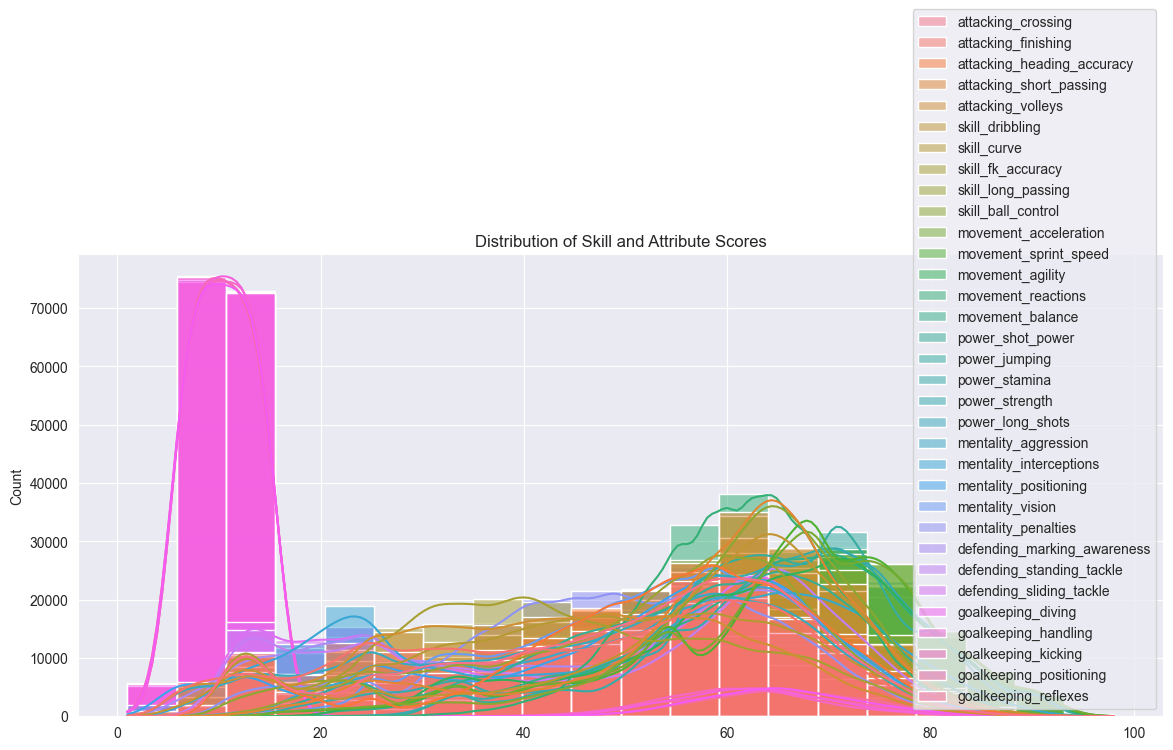

In [8]:
# Distribution of Skill and Attribute Scores
plt.figure(figsize=(14, 6))
sns.histplot(data.drop(columns=['player_id']), bins=20, kde=True)
plt.title('Distribution of Skill and Attribute Scores')
plt.show()

Here we get a pretty good look at the distributions of all these numerical attributes. They have a vaguely bellshape distribution that is gathered towards 65 and stretches pretty far out to the left towards the lower numbers in the graph. An interesting but also expected outlier here is the large pink bars on the left, which are all the goal keeping stats. These are generally stats the only goalkeepers will have high values leading to the large distribution of them at the bottom. Now lets take a look at feature correlation.

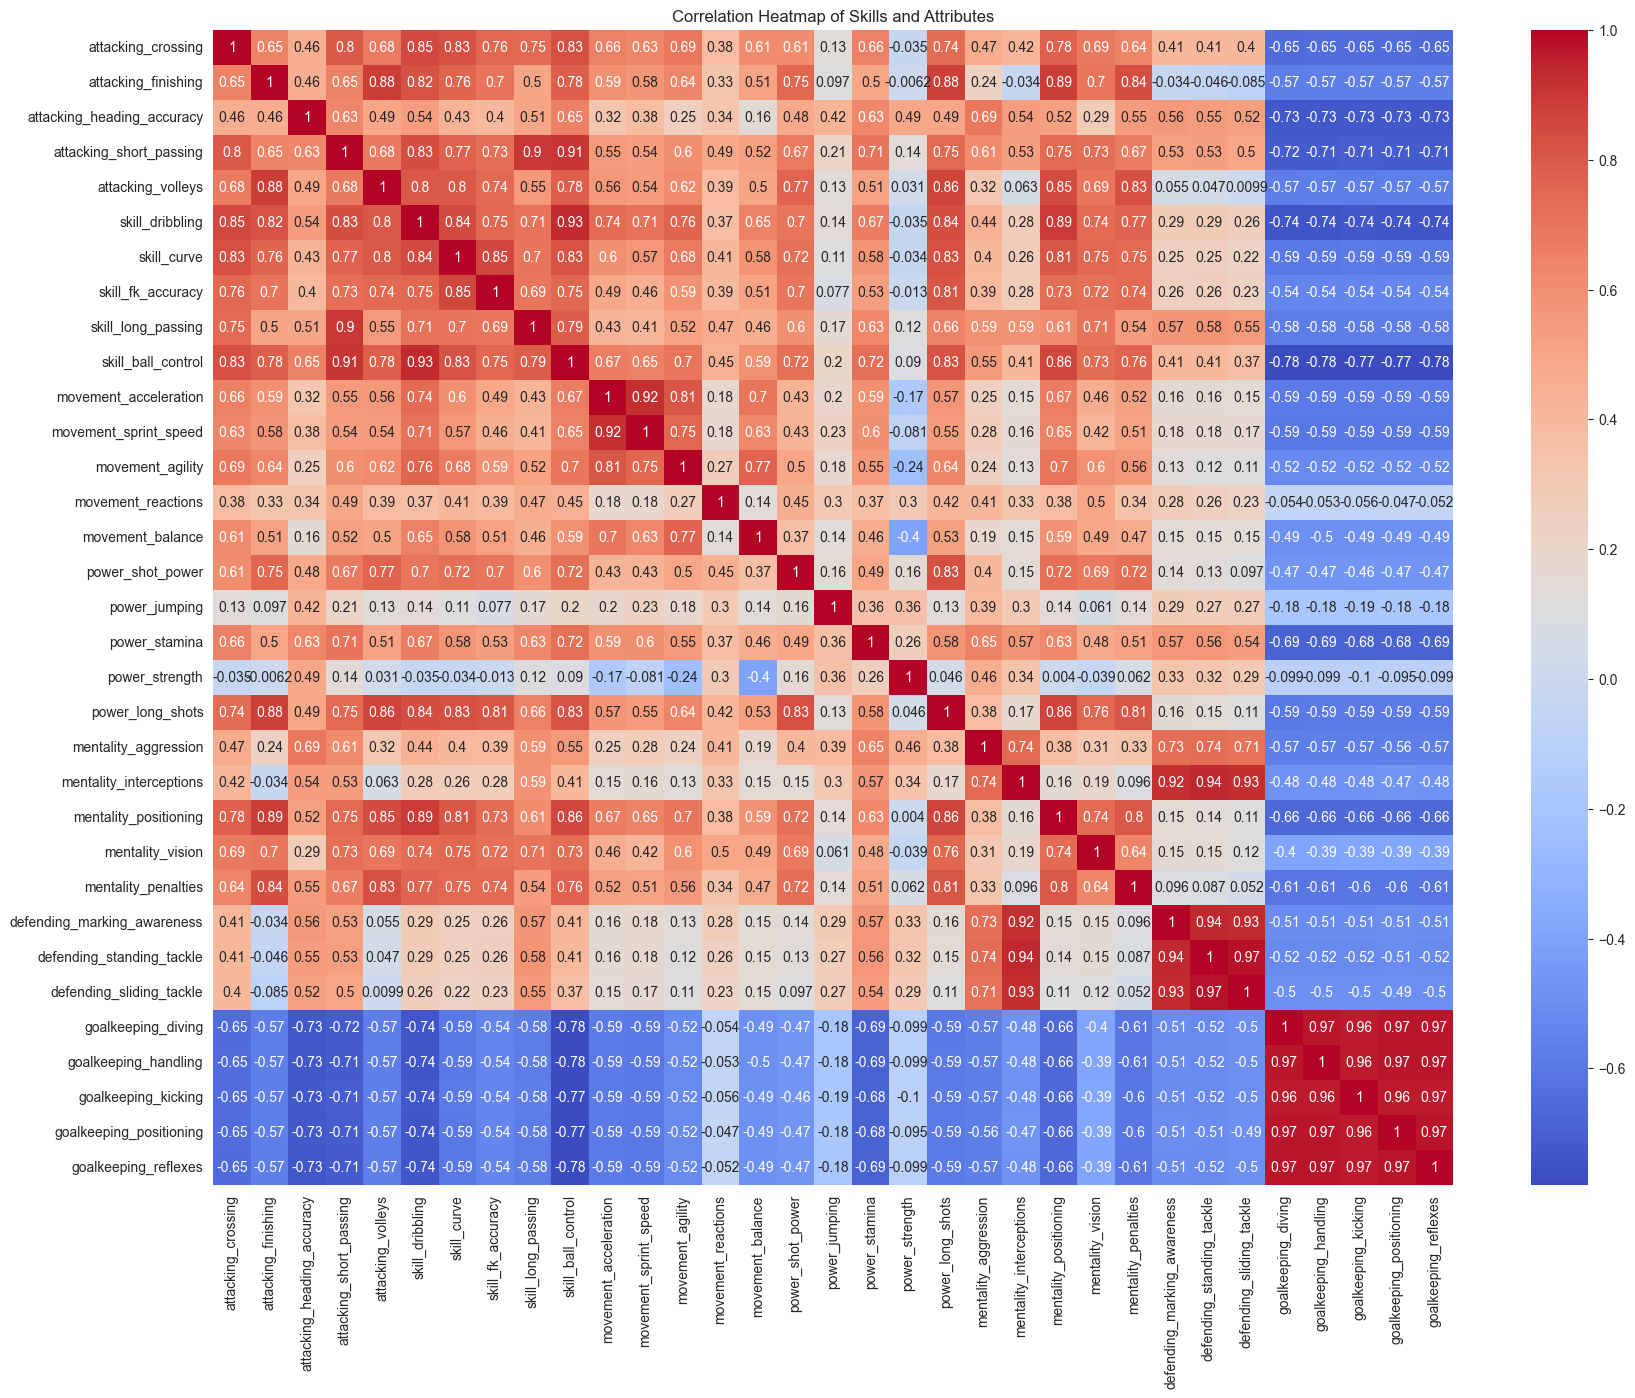

In [9]:
# Correlation Heatmap
plt.figure(figsize=(20, 15))
sns.heatmap(data.drop(columns=['player_id','gen_position','short_name','player_positions', 'primary_position']).corr(), annot=True, cmap='coolwarm')
plt.title('Correlation Heatmap of Skills and Attributes')
plt.show()

Here we can see the correlation heatmap of all the features. As expected, theres a pretty low correlation between the goalkeeping stats and attacking stats, while a lot of the attacking skill stats are closely related with things like passing and ball control, or powershots and finishing. Many of the attacking traits are linked, while defending and goalkeeping traits are strongly linked as well. 

Now we'll take a look at positional distributions.

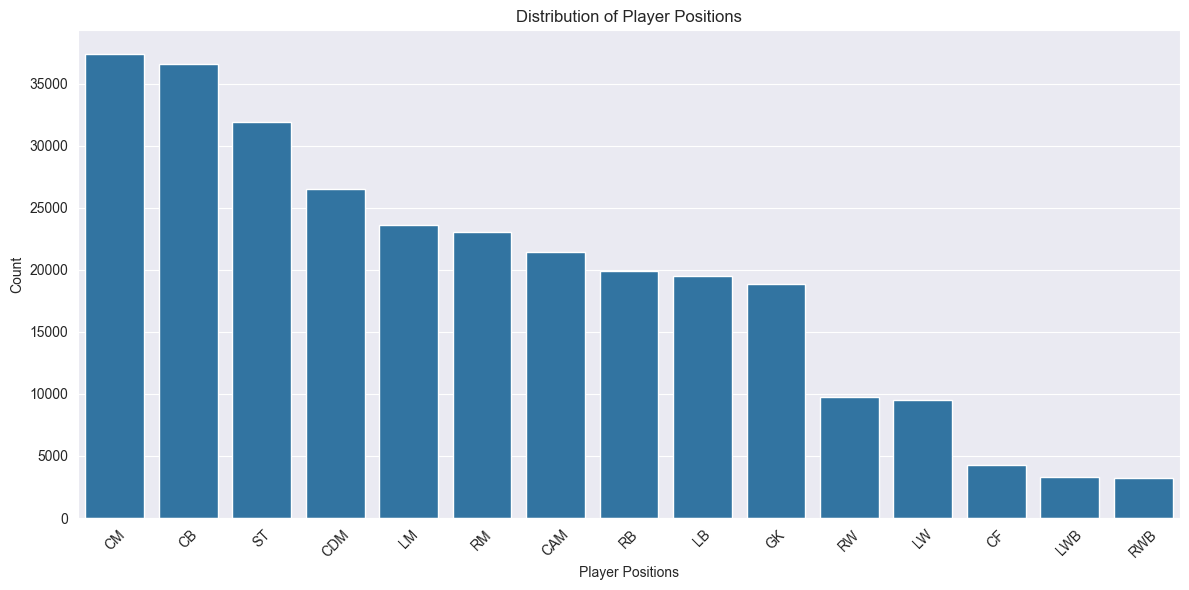

In [10]:
# Flatten the player_positions list and create a new DataFrame
positions_df = pd.DataFrame(data['player_positions'].explode())

# Plot distribution of player_positions
plt.figure(figsize=(12, 6))
sns.countplot(data=positions_df, x='player_positions', order=positions_df['player_positions'].value_counts().index)
plt.title('Distribution of Player Positions')
plt.xlabel('Player Positions')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()



We have a wide range of counts for the different positions which can be both a good and bad thing. We have a lot of data for CM, CB, and ST positions and not much for CF,LWB, and RWB. We'll see if those positions turn out to have a better or worse accuracy in our predictions. Lets look at the general positioning. 

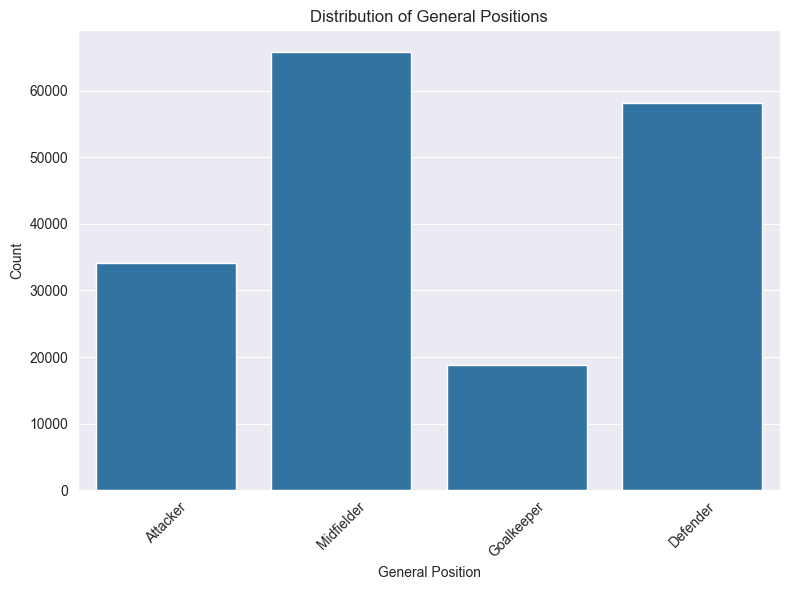

In [11]:
# Plot distribution of gen_position
plt.figure(figsize=(8, 6))
sns.countplot(data=data, x='gen_position')
plt.title('Distribution of General Positions')
plt.xlabel('General Position')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

As a soccer enjoyer, this graph is fairly expected, many midfielders and defenders, less attackers and much much less Goalkeepers. We can also note the difference in counts here and see how it affects our prediction performance. Lastly, lets take a look at how many players have multiple positions listed which can also add to the complexity of their attributes and therfore complexity in prediction. 

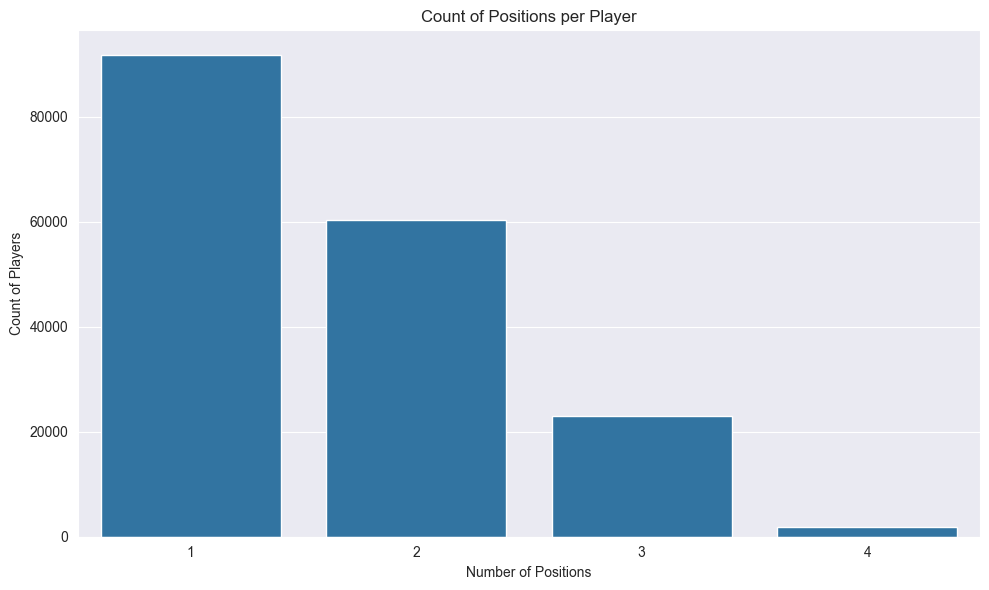

In [12]:
# Calculate the count of positions for each player
positions_count = data['player_positions'].apply(lambda x: len(x) if isinstance(x, list) else 0)

# Filter out players with 0 positions (if any)
positions_count = positions_count[positions_count > 0]

# Create a DataFrame with the counts
positions_count_df = pd.DataFrame(positions_count.value_counts().reset_index())
positions_count_df.columns = ['Number of Positions', 'Count of Players']

# Plot the count of positions per player
plt.figure(figsize=(10, 6))
sns.barplot(data=positions_count_df, x='Number of Positions', y='Count of Players')
plt.title('Count of Positions per Player')
plt.xlabel('Number of Positions')
plt.ylabel('Count of Players')
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

While a majority of players only have 1 position listed, we do have a large chunk that have mutiple which is something to note when creating our model and evaluating the predictions. Based on our EDA and the nature of our dataset, I'm going to use K-means clustering to predict the positionality of our players. We'll standardize the data to equalize the feature scales, as well as preserving the data distribution. 

## Building our Model: K-Means Clustering

Lets build our K-means clustering model, first attempting to split the clusters into the 15 distinct positions in the dataset. 

In [13]:
# Drop non-numeric 
numeric_data = data.select_dtypes(include=['number'])
scaler = StandardScaler()
scaled_data = scaler.fit_transform(numeric_data)

# Perform K-means clustering
kmeans = KMeans(n_clusters=15, random_state=42) 
kmeans.fit(scaled_data)

# Get cluster centers and cluster labels
cluster_centers = kmeans.cluster_centers_
cluster_labels = kmeans.labels_

# Assign cluster labels to data points
data['cluster_label'] = cluster_labels

Since we do in this case have ground truth labels in the data, lets see if we can find an agreeable mapping for the best possible accuracy in position label. One of the methods to do this is the adjusted_rand_score, which gives us a score between 1 and -1 showing the agreement between the clusters and the actual data positions (labels converted to numerics for the function). 

In [14]:
true_labels = all_positions
label_encoder = LabelEncoder()

encoded_labels = label_encoder.fit_transform(data['primary_position'])

# Calculate Adjusted Rand Index (ARI)
ari_score = adjusted_rand_score(encoded_labels, data['cluster_label'])

print("Adjusted Rand Index (ARI):", ari_score)



Adjusted Rand Index (ARI): 0.26633735366535977


Based off this ARI score we are leaning more towards random clusterization than a precise accurate clustering method. Lets try calculating the accuracy of when we try to use the generalized positions.

In [15]:
# Perform K-means clustering
kmeans = KMeans(n_clusters=4, random_state=42) 
kmeans.fit(scaled_data)

cluster_labels = kmeans.labels_

# Assign cluster labels to data points
data['cluster_label'] = cluster_labels

encoded_labels = label_encoder.fit_transform(data['gen_position'])

# Calculate Adjusted Rand Index (ARI)
ari_score = adjusted_rand_score(encoded_labels, data['cluster_label'])

print("Adjusted Rand Index (ARI):", ari_score)

Adjusted Rand Index (ARI): 0.36182735095619345


Here we have a slightly better score however it's still not as accurate as I'd like it to be. This may be because a lot of these positions have overlaps in what makes a player good in that position. Midfielders can be better at attacking or defending and can have the attributes that would put a prediction at odds. Lets filter our data to see how accurate this mapping was for each gen position. 

In [16]:
mappings = [
    {0: 'Attacker', 1: 'Midfielder', 2: 'Defender', 3: 'Goalkeeper'},
    {0: 'Midfielder', 1: 'Attacker', 2: 'Goalkeeper', 3: 'Defender'},
    {0: 'Defender', 1: 'Attacker', 2: 'Midfielder', 3: 'Goalkeeper'},
    {0: 'Goalkeeper', 1: 'Midfielder', 2: 'Attacker', 3: 'Defender'},
    {0: 'Attacker', 1: 'Defender', 2: 'Midfielder', 3: 'Goalkeeper'},
    {0: 'Midfielder', 1: 'Defender', 2: 'Goalkeeper', 3: 'Attacker'},
    {0: 'Defender', 1: 'Midfielder', 2: 'Attacker', 3: 'Goalkeeper'},
    {0: 'Goalkeeper', 1: 'Defender', 2: 'Midfielder', 3: 'Attacker'}
]

best_mapping = None
best_accuracy = 0

for mapping in mappings:
    # Map the numbers to labels using the current mapping
    mapped_labels = data['cluster_label'].map(mapping)

    # Calculate accuracy based on mapped labels and actual labels (gen_positions)
    accuracy = accuracy_score(data['gen_position'], mapped_labels)

    # Check if this mapping has higher accuracy than the previous best
    if accuracy > best_accuracy:
        best_accuracy = accuracy
        best_mapping = mapping

print("Best Mapping:", best_mapping)
print("Best Accuracy:", best_accuracy)

Best Mapping: {0: 'Midfielder', 1: 'Attacker', 2: 'Goalkeeper', 3: 'Defender'}
Best Accuracy: 0.4085084514121454


We can see from the mapping iteration above that our best accuracy for labels is 0.408 of the labels. Which is not very good. Lets see what the accuracy for each of the splits is. 

In [17]:
# Map the cluster labels using the best mapping
mapped_labels = data['cluster_label'].map(best_mapping)

# Calculate accuracy for each position label
positions = ['Attacker', 'Defender', 'Midfielder', 'Goalkeeper']
accuracies = {}

for position in positions:
    position_indices = data['gen_position'] == position
    position_true_labels = data.loc[position_indices, 'gen_position']
    position_mapped_labels = mapped_labels[position_indices]
    
    accuracy = accuracy_score(position_true_labels, position_mapped_labels)
    accuracies[position] = accuracy

print("Accuracy for each position label:")
for position, accuracy in accuracies.items():
    print(f"{position}: {accuracy:.2f}")

Accuracy for each position label:
Attacker: 0.82
Defender: 0.27
Midfielder: 0.15
Goalkeeper: 1.00


This is also fairly understandable results given the archetype for each of these very different and varied positions. Attackers have an 82% accuracy for prediction under this model, which makes sense as attackers tend to have very distinct abilities regrding shooting, dribbling and pace. Defender and midfielders are definitely difficult to predict as they can have a myriad of different attributes that many midfielders or Attackers have. For example a LB,LWB,RB,RWB might have similar abilities and attributes to that of a winger, and may also closely resemble the attribute profile of a midfielder. Lastly we can absolutely understand how Goalkeepers are 100% since their abilities are rather unique. Before trying to see what another model would predict, lets get some more understanding of how these clusters were wrong. 


In [18]:
from collections import Counter

# Calculate misclassifications for each position label and misclassified label
misclassifications = {position: Counter() for position in positions}
total_wrong = Counter()

for index, row in data.iterrows():
    true_position = row['gen_position']
    mapped_position = mapped_labels[index]
    if true_position != mapped_position:
        misclassifications[true_position][mapped_position] += 1
        total_wrong[true_position] += 1

# Calculate percentage of misclassification for each position label and misclassified label
misclassification_percentages = {position: {other_position: (count / total_wrong[position]) * 100 for other_position, count in misclassifications[position].items()} for position in positions}

print("Percentage of misclassification for each position label and misclassified label:")
for position, misclassified_labels in misclassification_percentages.items():
    print(f"{position}:")
    for other_position, percentage in misclassified_labels.items():
        print(f"  Misclassified as {other_position}: {percentage:.2f}%")


Percentage of misclassification for each position label and misclassified label:
Attacker:
  Misclassified as Defender: 97.76%
  Misclassified as Midfielder: 2.23%
  Misclassified as Goalkeeper: 0.02%
Defender:
  Misclassified as Midfielder: 98.50%
  Misclassified as Attacker: 1.49%
  Misclassified as Goalkeeper: 0.00%
Midfielder:
  Misclassified as Defender: 58.49%
  Misclassified as Attacker: 41.51%
Goalkeeper:


With some futher breakdown statistics we can see that for midfield it was split on being mistaken for a Defender/Attacker. Attackers tended to be misclassified as Defenders and Defenders were mostly seen as midfielders. I imagine the Attackers being mistaken for defenders could be due to the physical attributes some attackers have, and the defenders can be skewed towards attackers due to LWB, LB, RB, AND RWB positions which can share a lot of similarities. Now lets see what Logistic Regression can do to predict both the positions as well as the general predictions and compare across the two.

In [19]:
# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(numeric_data, data['primary_position'], test_size=0.2, random_state=42)

# Initialize Logistic Regression model
logreg_model = LogisticRegression(random_state=42)

# Train the model
logreg_model.fit(X_train, y_train)

# Make predictions on the testing set
y_pred = logreg_model.predict(X_test)

# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

Accuracy: 0.5839898348157561


C:\Users\jmosc\OneDrive\OMDS\Unsupervised Algorithms in Machine Learning\Final Project\.venv\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Interestingly enough we get a higher accuracy score with the full 15 predicted positions for the data set. I think this might be a better fit than the K-means clustering because it has knowledge of the labels and builds its predictions based off that in the training set. K-means has difficulty when data points are necessarily clustered together. This is true of this data set since there are wide ranges of attributes for specific positions. And two players of the same position might better resemble other positions before ever seeming similar to eachother. Lets see how the Logistic Regression does with the 4 labels. I imagine it might do better. 

In [20]:
# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(numeric_data, data['gen_position'], test_size=0.2, random_state=42)

# Initialize Logistic Regression model
logreg_model = LogisticRegression(random_state=42)

# Train the model
logreg_model.fit(X_train, y_train)

# Make predictions on the testing set
y_pred = logreg_model.predict(X_test)

# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

Accuracy: 0.8428067203162501


C:\Users\jmosc\OneDrive\OMDS\Unsupervised Algorithms in Machine Learning\Final Project\.venv\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


As expected, this method is less thrown off by the varied aspects of each label and fits closer to the varying data than a clustering method would. With an accuracy of 84% I'm pretty happy given how minute the difference between an attacker, defender, and midfielder might be on paper. 

## Discussion and Conclusion

In this project, we set out to see if we could cluster the player data from FIFA 24 along positional lines. After testing a K-means cluster model as well as a Logistic Regression model, we saw the supervised method far outperform our unsupervised method. There are several reasons for this the first of which being the nature of the data. 

The player attributes data in any FIFA game is widely varied from player to player within each position and even within each general positioning (ATT,MID,DEF,GK). This inherent complexity makes it really challenging for clustering algorithms such as K-means to properly group players based off the attributes. On top of this, the supervised approach to this gives clear advantage as well since the algorithm is allowed a more nuanced approach, having the correct labels to work with in the training data set. 

Based on this project's analysis we find Logistic Regression a much better model for fitting positions in soccer based on widely diverse skills and attributes. For future analysis it might be interesting dig deeper into the data maybe going specifically into  the differences of midfielders and how closely they resemble other positions. It might also be interesting to see what the clusters of players that might show up based off all these attributes outside positional. 

## Sources

https://www.kaggle.com/datasets/rehandl23/fifa-24-player-stats-dataset